In [1]:
import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data_dir = '/content/gdrive/My Drive/AI_SIC_PROJECT/D'  

In [4]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=(416, 416),
                       batch_size=8)


In [5]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = True 

if do_data_augmentation:
   train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=False, **dataflow_kwargs)

Found 845 images belonging to 2 classes.
Found 3387 images belonging to 2 classes.


Training the model

In [6]:
from keras.layers import Dense
from keras.layers import Dropout

In [7]:
def create_model(num_classes=2):
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=(None, None, 3)) 
  
  model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255), # rescale image pixels between 0 & 1                           
    feature_extractor_layer, # use the feature extraction layer as the base
    Dropout(0.3),
    Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])
  return model

In [8]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [9]:
m = create_model()
m.build([None, None, None, 3])

In [10]:
from keras.callbacks import EarlyStopping
# Set callback functions to early stop training 
mycallbacks = [EarlyStopping(monitor='val_loss', patience=2)]

In [ ]:
from tensorflow.keras import optimizers
m.compile(loss='binary_crossentropy',
                           optimizer=optimizers.RMSprop(lr=2e-5),
                           metrics=['accuracy'])


efficientnetb0_v2_history = m.fit(train_generator,
                                  validation_data=valid_generator,
                                  validation_steps=len(valid_generator),
                                  epochs=10, 
                                  callbacks=[mycallbacks,create_tensorboard_callback(dir_name="effnetv1_vs_effnetv2",experiment_name = 'efficientv2-l')]) # name of log files)

# **Saving the model**

In [13]:
m.save('my_model')
m.save_weights('my_model_weights.h5')

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [22]:
import cv2
from PIL import Image


In [18]:
import zipfile
with zipfile.ZipFile("EfficientNet_test.zip","r") as zip_ref:
    zip_ref.extractall("/content")

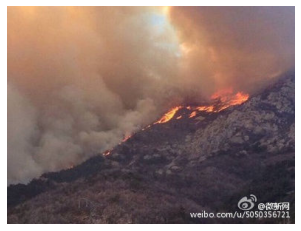

[[0.5582958 0.4417042]]
fire


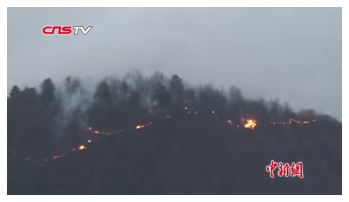

[[0.67296433 0.32703567]]
fire


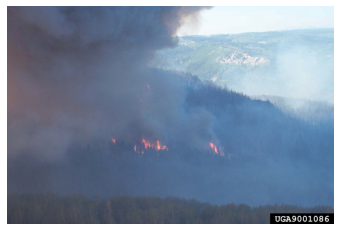

[[0.65494174 0.3450583 ]]
fire


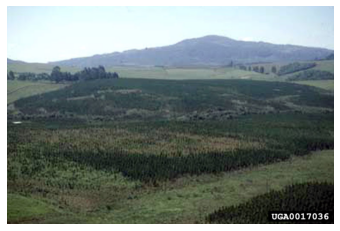

[[0.9363716  0.06362836]]
fire


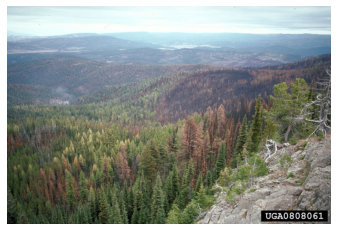

[[0.47139695 0.5286031 ]]
sunset


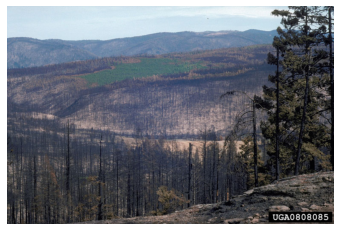

[[0.29456753 0.7054325 ]]
sunset


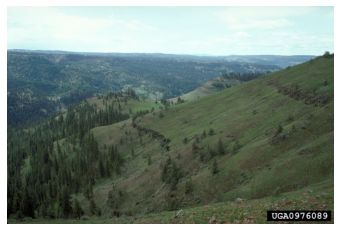

[[0.8873447  0.11265528]]
fire


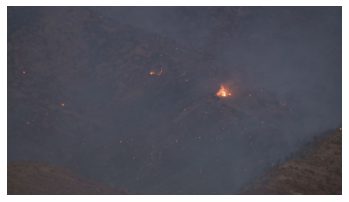

[[0.8916945  0.10830554]]
fire


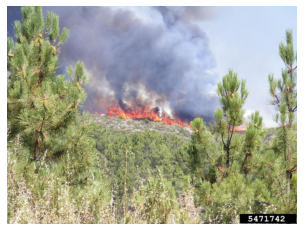

[[0.14508817 0.85491186]]
sunset


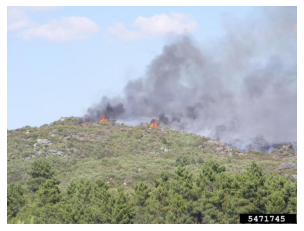

[[0.56561124 0.43438876]]
fire


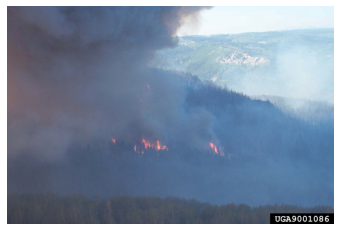

[[0.65494174 0.3450583 ]]
fire


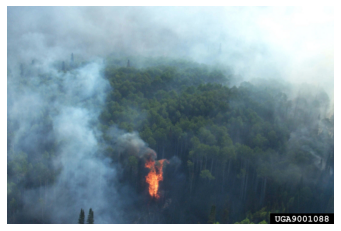

[[0.80014515 0.19985485]]
fire


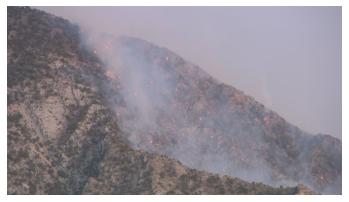

[[0.92776364 0.07223634]]
fire


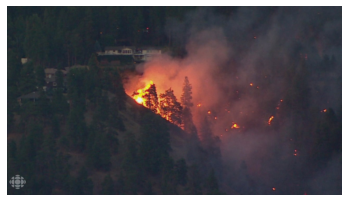

[[0.92452437 0.07547561]]
fire


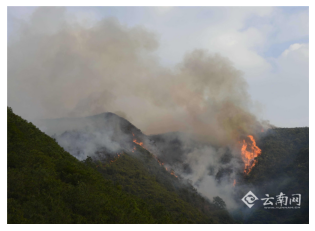

[[0.5230888 0.4769112]]
fire


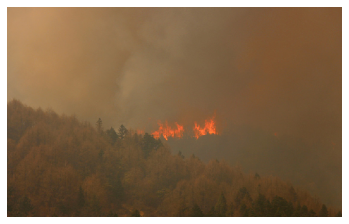

[[0.821261   0.17873895]]
fire


In [23]:
claass =['fire','sunset']
for i in range(2,18):
 image = Image.open("/content/EfficientNet_test/{}.jpg".format(i))
 plt.imshow(image)
 plt.axis('off')
 plt.show()
 prediction_scores = m.predict(np.expand_dims(image, axis=0))
 predicted_index = np.argmax(prediction_scores)
 print(prediction_scores)
 print(claass[predicted_index])